In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import clip
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

from superlinked.framework.common.schema.id_schema_object import IdField
from superlinked.framework.common.schema.schema import schema
from superlinked.framework.common.schema.schema_object import Array, Float
from superlinked.framework.dsl.index.index import Index
from superlinked.framework.dsl.space.custom_space import CustomSpace
from superlinked.framework.dsl.query.param import Param
from superlinked.framework.dsl.space.number_space import NumberSpace, Mode

from superlinked.framework.dsl.executor.in_memory.in_memory_executor import (
    InMemoryExecutor,
)
from superlinked.framework.dsl.source.in_memory_source import InMemorySource
from superlinked.framework.dsl.query.query import Query

/home/andrey/Work/projects/caption-match/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_NAME = "ViT-B/32"
EMBEDDING_SIZE = 512
PHOTO_FOLDER = "../data/unsplash"

In [3]:
model, preprocess = clip.load(MODEL_NAME)

# Functions

In [4]:
def calculate_brightness(image: Image) -> float:
    grayscale_image = image.convert("L")
    mean_brightness = np.mean(grayscale_image.getdata())
    return mean_brightness

In [5]:
def load_dataset(folder: Path) -> list[dict]:
    items = []
    for filename in tqdm(folder.glob("*.jpg")):
        image_raw = Image.open(filename)
        image_raw.thumbnail((512, 512))
        brightness = calculate_brightness(image_raw)
        image = preprocess(image_raw)
        item = {
            "filename": filename,
            "name": filename.name,
            "image_raw": image_raw,
            "image_preprocessed": image,
            "brightness": brightness,
        }
        items.append(item)        
    return items

In [23]:
def display_images(names, dataset, name_to_index):

    n = len(names)
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(3 * n, 3))

    if n == 1:
        axes = [axes]

    for ax, name in zip(axes, names):
        index = name_to_index[name]
        item = dataset[index]
        image = item["image_raw"]
        ax.imshow(image)
        ax.axis("off")
        brightness = item["brightness"]
        ax.set_title(int(brightness))

    plt.show()

# Load data

In [6]:
dataset = load_dataset(Path(PHOTO_FOLDER))

31it [00:06,  4.66it/s]


In [7]:
name_to_index = {x["name"]: i for i, x in enumerate(dataset)}

In [8]:
@schema
class Photo:
    name: IdField
    brightness: Float
    features: Array


photo = Photo()

photo_features_space = CustomSpace(vector=photo.features, length=EMBEDDING_SIZE)
photo_brightness_space = NumberSpace(
    number=photo.brightness, min_value=0, max_value=256, mode=Mode.SIMILAR
)
photo_index = Index(spaces=[photo_features_space, photo_brightness_space])

In [9]:
source = InMemorySource(photo)
executor = InMemoryExecutor(sources=[source], indices=[photo_index])
app = executor.run()

In [10]:
items = []

for x in tqdm(dataset):
    features = model.encode_image(x["image_preprocessed"].unsqueeze(0)).squeeze().detach().numpy()
    item = {"name": x["name"], "brightness": x["brightness"], "features": features}
    items.append(item)

100%|██████████| 31/31 [00:02<00:00, 11.47it/s]


In [11]:
source.put(items)

# Retrieval

In [20]:
photo_query = (
    Query(
        photo_index,
        weights={
            photo_features_space: Param("features_weight"),
            photo_brightness_space: Param("brightness_weight"),
        },
    )
    .find(photo)
    .similar(photo_features_space.vector, Param("features"))
    .similar(photo_brightness_space.number, Param("brightness"))
    .limit(5)
)

In [28]:
# captions = ["photo of a dog"]
# captions = ["photo of a car"]
captions = ["car on the bridge"]

texts = clip.tokenize(captions)

with torch.no_grad():
    text_features = model.encode_text(texts)

text_features = text_features[0].detach().numpy()

In [33]:
result = app.query(
    photo_query,
    features=text_features,
    brightness=256,
    features_weight=1,
    brightness_weight=-0.1,  # darker is better
)

In [34]:
df = pd.DataFrame([entry.stored_object for entry in result.entries]).drop(
    columns=["features"]
)
df

,brightness,name
0,10.608624,samuele-errico-piccarini-FMbWFDiVRPs-unsplash.jpg
1,41.098968,ville-kaisla-HNCSCpWrVJA-unsplash.jpg
2,122.915500,martin-katler-7eanf8kRpJI-unsplash.jpg
3,136.815599,erik-mclean-ZRns2R5azu0-unsplash.jpg
4,125.443629,erik-odiin-DH_IAgZkJP4-unsplash.jpg


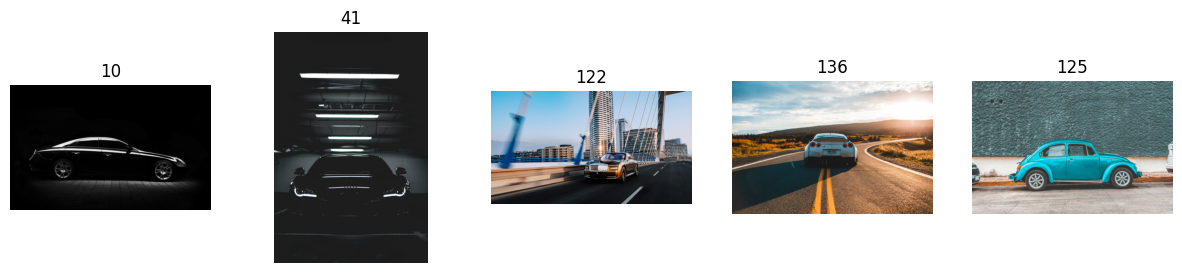

In [35]:
names = [entry.stored_object["name"] for entry in result.entries]
display_images(df.name, dataset=dataset, name_to_index=name_to_index)

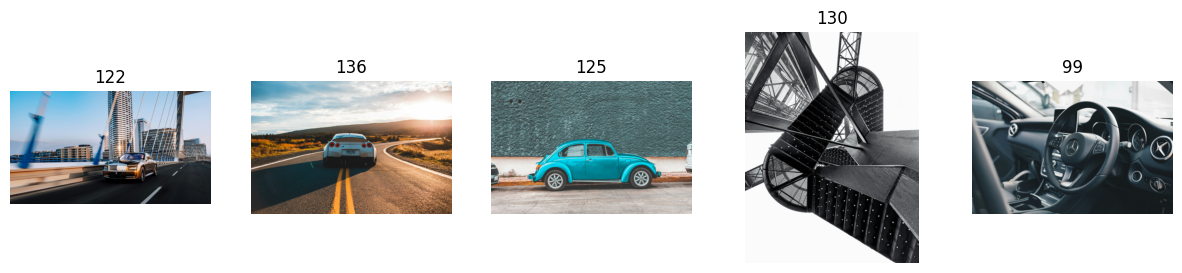

In [36]:
result = app.query(
    photo_query,
    features=text_features,
    brightness=256,
    features_weight=1,
    brightness_weight=0.1,  # lighter is better
)

names = [entry.stored_object["name"] for entry in result.entries]
display_images(names, dataset=dataset, name_to_index=name_to_index)